# e/iso/sQTL overlap
- `pi0`: the proportion of true null association based on their distribution
- `pi1=1-pi0` estimates the lower bound of true positive associations
- `lambda = 0` meaning `pi0 = 1`
- Notes
    - tried nominal association, large file; tested with one chunk, see results below
    - tried w/ and w/o filling in NA p-val with random uniform distribution; ERROR when w/o
    - tried use permutation/primary gene-QTL assoc for both groups, bad result (many missing, too many random fill)
    - `qvalue` error when no right tail of p-val distribution "The p-values are relatively flat at the right tail of the histogram. This is an important step in determining whether the true null p-values are distributed according to a Uniform(0,1) distribution" (from qvalue package)
    - **final: permutation significant gene-SNP pair in discovery group, filling in NA pval nominal association for replication group**
    - what to use for `lambda`? `seq(0.2, 0.8, 0.1)` as in Jason Stein's paper makes minimal difference to w/o `lambda` for nominal chunk testing
    - `pval_beta` and `pval_nominal` makes minimal difference, see below
    - **see final results at the end** 

In [1]:
library(data.table)
library(tidyverse)
library(qvalue)
library(viridis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()

Loading required package: viridisLite



In [2]:
setwd("~/project-gandalm/isoform_twas/")

### 1: iso/s QTL replicated in eQTL

In [38]:
isoqtl <- fread("isoqtl_new/results/mixed_grp_perm_70hcp/group.perm.genes.txt.gz", data.table = F)
sqtl <- fread("sqtl_new/results/mixed_grp_perm_40hcp_1e6/group.perm.genes.txt.gz", data.table = F)
eqtl_nominal <- eqtl_nominal <- fread("eqtl_new/results/mixed_nominal_70hcp/chunk1.txt.gz", data.table = F)

In [39]:
isoqtl <- isoqtl %>% separate(gene_id, c("pheno", "gene"), remove = FALSE, sep = ":") %>%
    unite("gene_qtl", gene, variant_id, remove = FALSE, sep = ":")

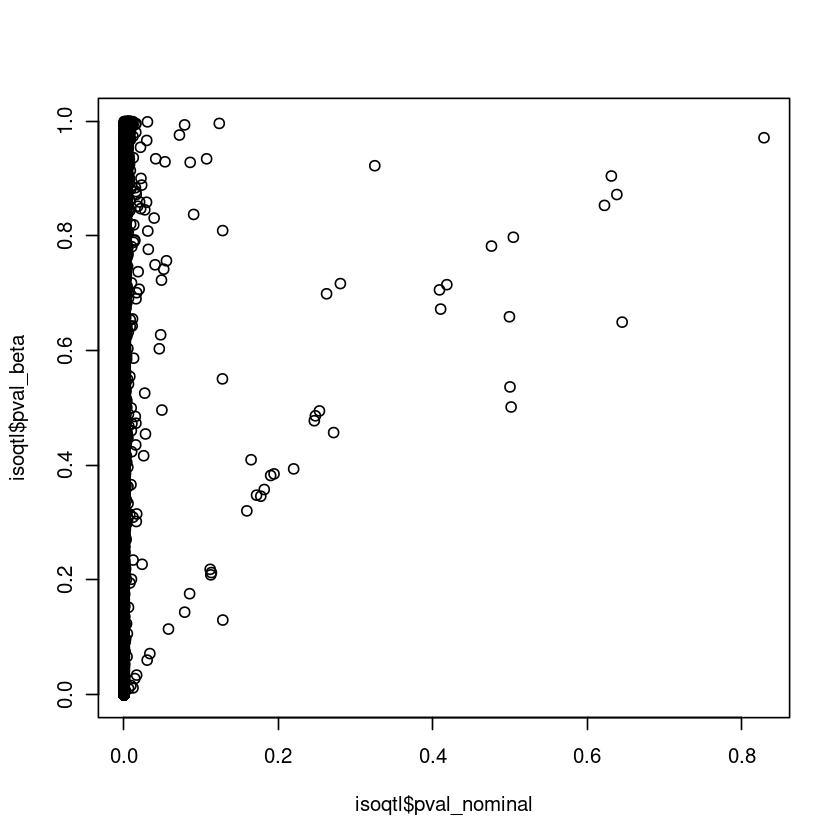

In [40]:
plot(isoqtl$pval_nominal, isoqtl$pval_beta)

In [35]:
dim(isoqtl)
length(unique(isoqtl$gene_qtl))

[1] 30752    24

[1] 30746

In [41]:
isoqtl <- isoqtl %>% arrange("gene_qtl", pval_beta)
isoqtl <- isoqtl[!duplicated(isoqtl$gene_qtl),]

In [42]:
sqtl <- sqtl %>% separate(gene_id, c("chr", "start", "end", "clu", "ensg", "gene_name"), sep = ":") %>%
    separate(ensg, c("gene", "version"), sep = "[.]") %>%
    unite("gene_qtl", gene, variant_id, sep = ":")

In [43]:
dim(sqtl)
length(unique(sqtl$gene_qtl))
sqtl <- sqtl %>% arrange("gene_qtl", pval_beta)
sqtl <- sqtl[!duplicated(sqtl$gene_qtl),]
dim(sqtl)
length(unique(sqtl$gene_qtl))

[1] 18424    26

[1] 16503

[1] 16503    26

[1] 16503

In [44]:
colnames(eqtl_nominal) <- c("pid","sid","dist","npval","slope")
eqtl_nominal <- eqtl_nominal %>% unite("gene_qtl", pid, sid, remove = FALSE, sep = ":")

[1] 11857    29

[1] 11697

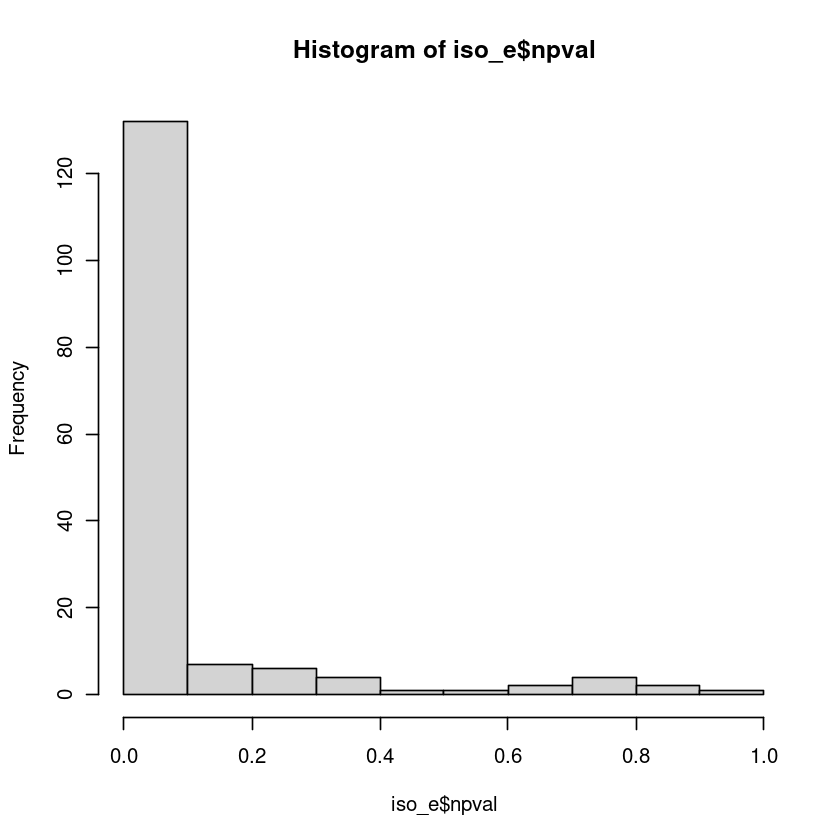

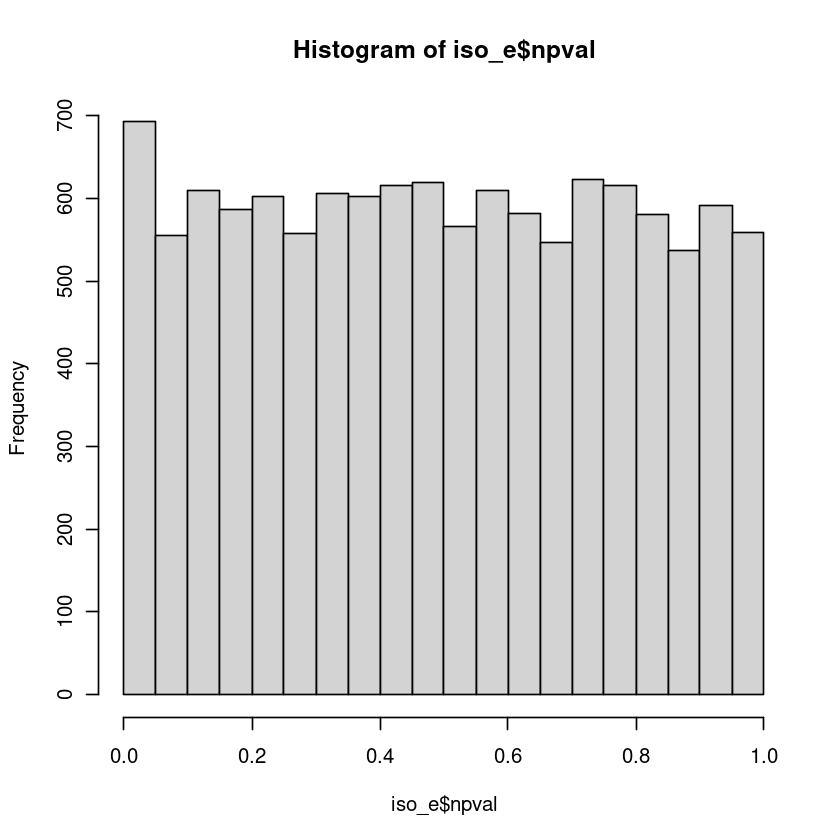

In [45]:
iso_e <- isoqtl %>%
    filter(qval < 0.05) %>%
    left_join(eqtl_nominal, by = "gene_qtl")
dim(iso_e)
hist(iso_e$npval)
sum(is.na(iso_e$npval))
for(i in 1:nrow(iso_e)) {
    if(is.na(iso_e[i,'npval'])) {
        iso_e[i,'npval'] <- runif(1, min = 0, max = 1)
    }
}
hist(iso_e$npval)

In [46]:
(qvalue(iso_e$npval))$pi0
(qvalue(iso_e$npval, lambda = seq(0.2, 0.8, 0.1)))$pi0

[1] 0.9522103

[1] 0.9636783

In [47]:
s_e <- sqtl %>%
    filter(qval < 0.05) %>%
    left_join(eqtl_nominal, by = "gene_qtl")
sum(is.na(s_e$npval))
for(i in 1:nrow(s_e)) {
    if(is.na(s_e[i,'npval'])) {
        s_e[i,'npval'] <- runif(1, min = 0, max = 1)
    }
}

(qvalue(s_e$npval))$pi0
(qvalue(s_e$npval, lambda = seq(0.2, 0.8, 0.1)))$pi0

[1] 7512

[1] 0.9876258

[1] 0.9654463

### 2: e/sQTL replicated in isoQTL

### 3: e/isoQTL replicated in sQTL

In [3]:
isoqtl <- fread("isoqtl_new/results/mixed_grp_perm_70hcp/group.perm.genes.txt.gz", data.table = F)
isoqtl <- isoqtl %>% 
    separate(gene_id, c("pheno", "gene"), remove = FALSE, sep = ":") %>%
    unite("gene_qtl", gene, variant_id, remove = FALSE, sep = ":") %>%
    arrange("gene_qtl", pval_beta)
isoqtl <- isoqtl[!duplicated(isoqtl$gene_qtl),]

eqtl <- fread("eqtl_new/results/mixed_perm_90hcp/sig_pheno.txt", data.table = F)
eqtl <- eqtl %>% 
    unite("gene_qtl", pid, sid, remove = FALSE, sep = ":")

In [5]:
ptm <- proc.time()

sqtl_nominal <- fread("sqtl_new/results/mixed_nominal_40hcp_1e6/chunk44.txt.gz", data.table = F)
load("sqtl_new/leafviz_annot/all.introns.tested.RData")
colnames(sqtl_nominal) <- c("pid","sid","dist","npval","slope")
sqtl_nominal <- sqtl_nominal %>% 
    left_join(pheno, by = c("pid" = "ID")) %>%
    separate(ensemblID, c("ensg", "ver"), sep = "[.]", remove = FALSE) %>%
    unite("gene_qtl", ensg, sid, remove = FALSE, sep = ":") %>%
    arrange('gene_qtl', npval)
sqtl_nominal <- sqtl_nominal[!duplicated(sqtl_nominal$'gene_qtl'),]

proc.time() - ptm

   user  system elapsed 
272.684  15.650 285.321 

In [7]:
ptm <- proc.time()

sqtl_nominal <- fread("sqtl_new/results/mixed_nominal_40hcp_1e6/chunk44.txt.gz", data.table = F)
load("sqtl_new/leafviz_annot/all.introns.tested.RData")
colnames(sqtl_nominal) <- c("pid","sid","dist","npval","slope")
sqtl_nominal <- sqtl_nominal %>% 
    select(pid, sid, npval) %>%
    left_join(pheno, by = c("pid" = "ID")) %>%
    separate(ensemblID, c("ensg", "ver"), sep = "[.]", remove = FALSE) %>%
    unite("gene_qtl", ensg, sid, remove = FALSE, sep = ":") %>%
    arrange('gene_qtl', npval) %>%
    select(gene_qtl, npval)
sqtl_nominal <- sqtl_nominal[!duplicated(sqtl_nominal$'gene_qtl'),]

proc.time() - ptm

   user  system elapsed 
248.334   7.732 252.672 

In [9]:
e_s <- eqtl %>%
    left_join(sqtl_nominal, by = "gene_qtl")
sum(is.na(e_s$npval.y))
for(i in 1:nrow(e_s)) {
    if(is.na(e_s[i,'npval.y'])) {
        e_s[i,'npval.y'] <- runif(1, min = 0, max = 1)
    }
}
(qvalue(e_s$npval.y))$pi0
(qvalue(e_s$npval.y, lambda = seq(0.2, 0.8, 0.1)))$pi0

[1] 10041

[1] 1

[1] 1

In [76]:
df <- data.frame("grp1" = c("eQTL", "isoQTL", "eQTL", "sQTL", "isoQTL", "sQTL", "eQTL", "isoQTL", "sQTL"),
                 "grp2" = c("isoQTL", "eQTL", "sQTL", "eQTL", "sQTL", "isoQTL", "eQTL", "isoQTL", "sQTL"),
                 "pi1" = c(1-Q_e_iso$pi0, 1-Q_iso_e$pi0, 1-Q_e_s$pi0, 
                           1-Q_s_e$pi0, 1-Q_iso_s$pi0, 1-Q_s_iso$pi0,
                           1, 1, 1))

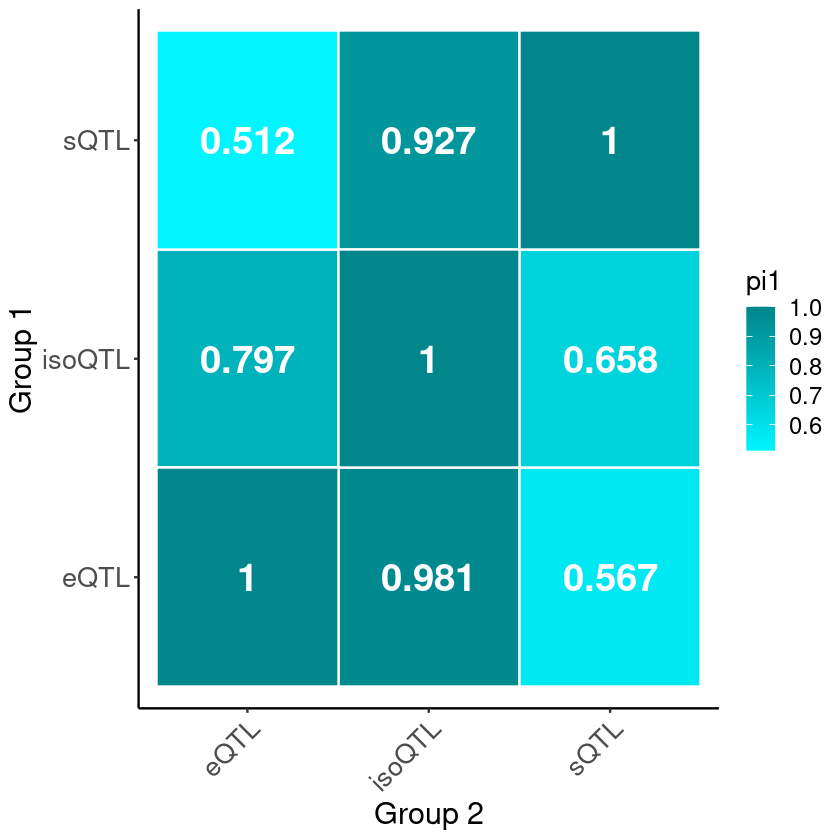

In [83]:
df$grp1 <- factor(df$grp1, levels = c("eQTL", "isoQTL", "sQTL"))
df$grp2 <- factor(df$grp2, levels = c("eQTL", "isoQTL", "sQTL"))

p <- ggplot(df, aes(x = grp2, y = grp1, fill = pi1)) +
    geom_tile(colour = "white", size = 0.5) +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right") +
    scale_fill_gradient(low = "turquoise1", high = "turquoise4") +
    geom_text(aes(label = signif(pi1, 3)), color = "white", size = 8, fontface = "bold") +
    labs(x = "Group 2", y = "Group 1")
p

### Final results
- for iso-iso/s-s/e-e, previously just used pi1=1
- now calculated pi1 from gene-QTL pairs from permutation (grouped permutation for iso/s), and nominal significant (most permutation significant pairs are also nominally significant)

**iso-iso**

In [17]:
isoqtl_perm <- fread("isoqtl_new/results/mixed_grp_perm_70hcp/group.perm.genes.txt.gz", data.table = F)

In [18]:
# I don't understand why there is error
# This error usually occurs when most pvals are significant
# https://github.com/StoreyLab/edge/issues/13
(qvalue(isoqtl_perm$pval_nominal))$pi0

ERROR: Error in smooth.spline(lambda, pi0, df = smooth.df): missing or infinite values in inputs are not allowed


In [14]:
dim(isoqtl_perm)

[1] 30752    21

In [15]:
range(isoqtl_perm$pval_nominal)

[1] 5.74753e-204  8.29097e-01

**So now we filter for the group permutation significant gene-QTL pairs, and get their nominal pval from nominal association. This is the most consistent to iso-e and iso-s.**

In [19]:
isoqtl_perm <- isoqtl_perm %>% filter(qval < 0.05)

In [20]:
isoqtl_perm <- isoqtl_perm %>% 
    unite("gene_qtl", group_id, variant_id, remove = FALSE, sep = ":") %>%
    arrange("gene_qtl", pval_beta)
length(unique(isoqtl_perm$gene_qtl))

isoqtl_perm <- isoqtl_perm[!duplicated(isoqtl_perm$gene_qtl),]

dim(isoqtl_perm)

[1] 11857

[1] 11857    22

In [21]:
isoqtl_nominal <- fread("isoqtl_new/results/mixed_nominal_70hcp/significant_assoc.txt", data.table = F)

In [22]:
tx2gene <- fread("salmon/tx2gene_gencode_v33_noGeneVersion.tsv", data.table = F)

In [23]:
isoqtl_nominal <- isoqtl_nominal %>% left_join(tx2gene, by = c("pid" = "Tx")) %>%
    unite("gene_qtl", Gene, sid, remove = FALSE, sep = ":") %>%
    arrange('gene_qtl', npval) %>%
    select(gene_qtl, npval)
isoqtl_nominal <- isoqtl_nominal[!duplicated(isoqtl_nominal$'gene_qtl'),]
head(isoqtl_nominal)

,gene_qtl,npval
,<chr>,<dbl>
1,ENSG00000163682:chr4:39456250,5.74753e-204
2,ENSG00000244879:rs1201591863,2.87985e-187
3,ENSG00000244879:rs504781,3.53270e-187
4,ENSG00000269893:rs1242236771,1.24887e-186
5,ENSG00000269893:rs658642,4.68287e-186
6,ENSG00000168653:chr1:39049713,1.68296e-185


In [24]:
iso_iso <- isoqtl_perm %>% left_join(isoqtl_nominal, by = "gene_qtl")

In [25]:
sum(is.na(iso_iso$npval))

[1] 32

In [29]:
set.seed(123)
for(i in 1:nrow(iso_iso)) {
    if(is.na(iso_iso[i,'npval'])) {
        iso_iso[i,'npval'] <- runif(1, min = 0, max = 1)
    }
}

In [30]:
(qvalue(iso_iso$npval))$pi0

[1] 0.002824854

**e-e**

In [31]:
eqtl_perm <- fread("eqtl_new/results/mixed_perm_90hcp/sig_pheno.txt", data.table = F)
eqtl_perm <- eqtl_perm %>%
    unite("gene_qtl", pid, sid, remove = FALSE, sep = ":")

eqtl_nominal <- fread("eqtl_new/results/mixed_nominal_70hcp/significant_assoc.txt", data.table = F)
eqtl_nominal <- eqtl_nominal %>%
    unite("gene_qtl", pid, sid, remove = FALSE, sep = ":")

In [32]:
e_e <- eqtl_perm %>% left_join(eqtl_nominal, by = "gene_qtl")
sum(is.na(e_e$npval.y))

[1] 54

In [33]:
set.seed(123)
for(i in 1:nrow(e_e)) {
    if(is.na(e_e[i,'npval.y'])) {
        e_e[i,'npval.y'] <- runif(1, min = 0, max = 1)
    }
}

In [34]:
(qvalue(e_e$npval.y))$pi0

[1] 0.006872849

**s-s**
- First used grouped permutation significant gene-QTL pairs, but this is from GTEx pipeline and many gene-QTL pairs are not in nominal significant results/different gene mapping (1237 pairs, pi0 0.166856929192911). sQTL replication is lower in sQTL than in isoQTL. 
- Then used all nominal results, see `qvalue_s_s.R` in code. 942 pairs not in nominal results, pi0=0.1315527
- Try use naive permutation; so that the two sets of sQTLs files have the same gene mapping. 586 missing npval, pi0=0.03367218

In [40]:
sqtl_perm <- fread("sqtl_new/results/mixed_perm_40hcp_1e6/sig_pheno_gene_info.txt", data.table = F)
head(sqtl_perm)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,...,qval,pval_nominal_threshold,verdict,gene,ensemblID,ensg,version,transcripts,constitutive.score,gene_type
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1:100155428:100159575:clu_12419_NA,6287,1.08181,624.881,507.847,rs12130813,3989,5.03402e-15,0.549976,0.00009999,...,1.02143e-09,2.03115e-05,annotated,PALMD,ENSG00000099260.11_4,ENSG00000099260,11_4,ENST00000263174.9_3+ENST00000496843.1_1+ENST00000615664.1_1,1.00,protein_coding
2,1:100159478:100159575:clu_12419_NA,6286,1.03524,639.717,511.411,rs12130813,-61,4.24268e-16,-0.573580,0.00009999,...,2.85194e-10,1.59473e-05,cryptic_fiveprime,PALMD,ENSG00000099260.11_4,ENSG00000099260,11_4,.,0.00,protein_coding
3,1:100315657:100316531:clu_12429_NA,6376,1.03664,652.573,511.253,rs4397673,406903,5.24418e-07,0.293516,0.00129987,...,1.20457e-02,1.57403e-05,cryptic_fiveprime,AGL,ENSG00000162688.17_4,ENSG00000162688,17_4,.,0.00,protein_coding
4,1:100315971:100316531:clu_12429_NA,6375,1.01795,723.504,522.983,rs4397673,406589,4.78901e-09,-0.341932,0.00009999,...,2.53067e-04,1.29412e-05,annotated,AGL,ENSG00000162688.17_4,ENSG00000162688,17_4,ENST00000361915.8_3,0.33,protein_coding
5,1:100350259:100353546:clu_12434_NA,6347,1.02948,705.341,519.809,chr1:100533794,649090,2.65900e-06,-0.459701,0.00529947,...,3.97356e-02,1.40602e-05,cryptic_threeprime,AGL,ENSG00000162688.17_4,ENSG00000162688,17_4,.,0.00,protein_coding
6,1:100435718:100440527:clu_12439_NA,6215,1.02712,643.920,513.980,rs7556546,21709,2.43172e-12,-0.722283,0.00009999,...,4.71324e-07,1.52226e-05,annotated,SLC35A3,ENSG00000117620.15_7,ENSG00000117620,15_7,ENST00000427993.7_3+ENST00000638988.1_1+ENST00000640600.1_1+ENST00000638968.1_1,0.14,protein_coding


In [41]:
sqtl_perm <- sqtl_perm %>% 
#     separate(group_id, c("ensg", "version"), sep = "[.]") %>%
    unite("gene_qtl", ensg, sid, sep = ":") %>%
    arrange("gene_qtl", bpval)
sqtl_perm <- sqtl_perm[!duplicated(sqtl_perm$gene_qtl),]

In [35]:
sqtl_perm <- fread("sqtl_new/results/mixed_grp_perm_40hcp_1e6/group.perm.genes.txt.gz", data.table = F)
sqtl_perm <- sqtl_perm %>% filter(qval < 0.05)

In [37]:
sqtl_perm <- sqtl_perm %>% 
    separate(group_id, c("ensg", "version"), sep = "[.]") %>%
    unite("gene_qtl", ensg, variant_id, sep = ":") %>%
    arrange("gene_qtl", pval_beta)
sqtl_perm <- sqtl_perm[!duplicated(sqtl_perm$gene_qtl),]

In [44]:
sqtl_nominal <- fread("sqtl_new/results/mixed_nominal_40hcp_1e6/significant_assoc.txt", data.table = F)

In [46]:
load("sqtl_new/leafviz_annot/all.introns.tested.RData")
sqtl_nominal <- sqtl_nominal %>% 
    left_join(pheno, by = c("pid" = "ID")) %>%
    separate(ensemblID, c("ensg", "ver"), sep = "[.]") %>%
    unite("gene_qtl", ensg, sid, sep = ":") %>%
    arrange('gene_qtl', npval)
sqtl_nominal <- sqtl_nominal[!duplicated(sqtl_nominal$'gene_qtl'),]

In [47]:
s_s <- sqtl_perm %>% left_join(sqtl_nominal, by = "gene_qtl")
sum(is.na(s_s$npval))

for(i in 1:nrow(s_s)) {
    if(is.na(s_s[i,'npval'])) {
        s_s[i,'npval'] <- runif(1, min = 0, max = 1)
    }
}

(qvalue(s_s$npval))$pi0

[1] 1237

[1] 0.1668569

**Make plot**
- See bash and Snakefile for full results

In [3]:
df <- data.frame("grp1" = c("eQTL", "isoQTL", "eQTL", "sQTL", "isoQTL", "sQTL", "eQTL", "isoQTL", "sQTL"),
                 "grp2" = c("isoQTL", "eQTL", "sQTL", "eQTL", "sQTL", "isoQTL", "eQTL", "isoQTL", "sQTL"),
                 "pi1" = c(1-0.02046428, 1-0.1159089, 1-0.388718, 
                           1-0.401189, 1-0.3709601, 1-0.06178486,
                           1-0.00687284916153788, 1-0.00282485449835949, 1-0.03367218))

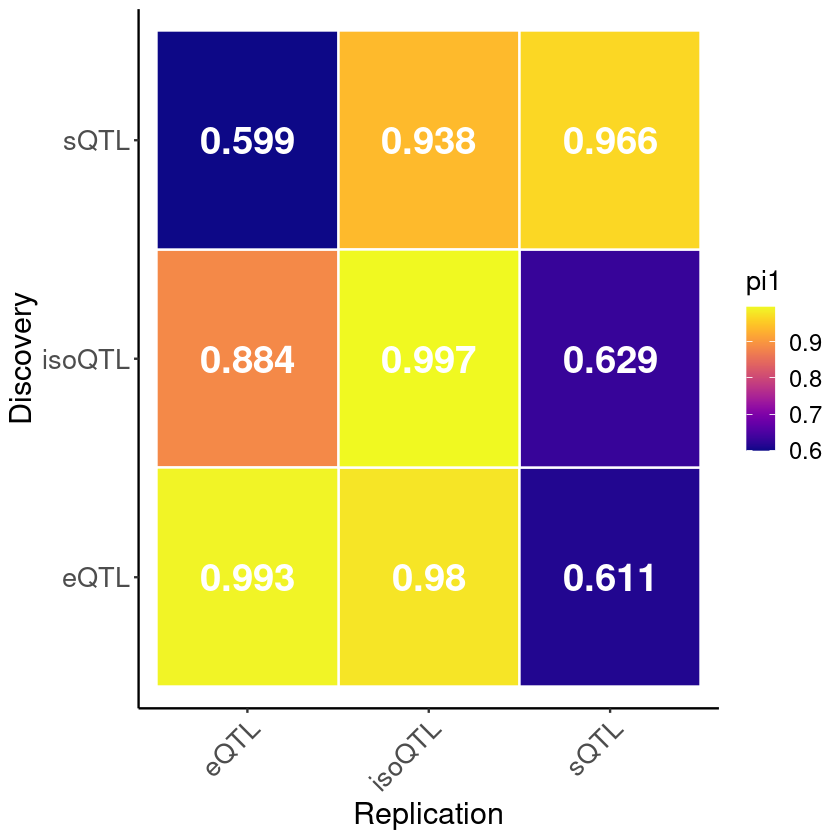

In [40]:
df$grp1 <- factor(df$grp1, levels = c("eQTL", "isoQTL", "sQTL"))
df$grp2 <- factor(df$grp2, levels = c("eQTL", "isoQTL", "sQTL"))

ggplot(df, aes(x = grp2, y = grp1, fill = pi1)) +
    geom_tile(colour = "white", size = 0.5) +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 16),
          axis.title = element_text(size = 18),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14),
          legend.position = "right") +
#     scale_fill_viridis(name = "Hrly Temps C", option = "C") +
#     scale_fill_gradient(low = 'white', high = 'darkblue') +
#     scale_fill_distiller(direction = 1, palette = "BuPu") +
    scale_fill_viridis(option = "C") + 
    geom_text(aes(label = signif(pi1, 3)), color = "white", size = 8, fontface = "bold") +
    labs(x = "Replication", y = "Discovery")

In [41]:
ggsave("sqtl_new/figures/pi1.pdf", height = 6, width = 6)

In [4]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /u/local/compilers/intel/2020.4/compilers_and_libraries_2020.4.304/linux/mkl/lib/intel64_lin/libmkl_gf_lp64.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] qvalue_2.24.0     forcats_0.5.1     stringr_1.4.0     dplyr_1.0.6      
 [5] purrr_0.3.4       readr_1.4.0       tidyr_1.1.3       tibble_3.1.2     
 [9] ggplot2_3.3.3     tidyverse_1.3.1   data.table_1.14.0

loaded via a namespace (and not attached):
